### Import dependences

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset

In [4]:
data_path = r"C:\Jave\Seasonality\dataset\001410010001_001410060000002201.csv"

In [5]:
data = pd.read_csv(data_path)
data.head()

,date,month,days,week_day,is_holiday_ever,quantity
0,2017-11-25,11,25,5,0,0.0
1,2017-11-26,11,26,6,0,0.0
2,2017-11-27,11,27,0,0,0.0
3,2017-11-28,11,28,1,0,0.0
4,2017-11-29,11,29,2,0,0.0


### Data analyzing

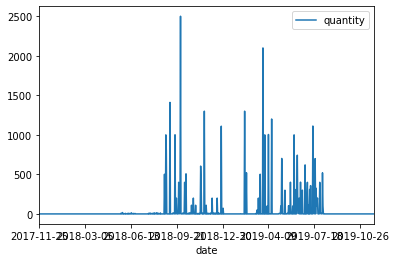

In [6]:
data.plot(x = 'date', y = 'quantity')

### Scale control variable

In [7]:
features_numericas = ['quantity']

In [8]:
scaled_features = {}

In [9]:
for item in features_numericas:
    mean, std = data[item].mean(), data[item].std()
    scaled_features[item] = [mean, std]
    data.loc[:, item] = (data[item] - mean)/std

In [10]:
print(data)

           date  month  days  week_day  is_holiday_ever  quantity
0    2017-11-25     11    25         5                0 -0.227635
1    2017-11-26     11    26         6                0 -0.227635
2    2017-11-27     11    27         0                0 -0.227635
3    2017-11-28     11    28         1                0 -0.227635
4    2017-11-29     11    29         2                0 -0.227635
..          ...    ...   ...       ...              ...       ...
727  2019-11-22     11    22         4                0 -0.227635
728  2019-11-23     11    23         5                0 -0.227635
729  2019-11-24     11    24         6                0 -0.227635
730  2019-11-25     11    25         0                0 -0.227635
731  2019-11-26     11    26         1                0 -0.227635

[732 rows x 6 columns]


### Dividindo os dados em treino, teste e validação

Salvaremos os últimos 21 dias dos dados para serem usados como um conjunto de testes depois de treinarmos a rede. Usaremos este conjunto para fazer previsões e compará-los com o número real de ciclistas.

In [11]:
# Salvando os últimos 21 dias
test_data = data[:20]
data = data[:20]

In [12]:
# Separando os dados em variáveis preditoras e variável target
target_fields = ['quantity']
features, targets = data.drop(target_fields, axis = 1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis = 1), test_data[target_fields]

print(features)
print(targets)

          date  month  days  week_day  is_holiday_ever
0   2017-11-25     11    25         5                0
1   2017-11-26     11    26         6                0
2   2017-11-27     11    27         0                0
3   2017-11-28     11    28         1                0
4   2017-11-29     11    29         2                0
5   2017-11-30     11    30         3                0
6   2017-12-01     12     1         4                0
7   2017-12-02     12     2         5                0
8   2017-12-03     12     3         6                0
9   2017-12-04     12     4         0                0
10  2017-12-05     12     5         1                0
11  2017-12-06     12     6         2                0
12  2017-12-07     12     7         3                0
13  2017-12-08     12     8         4                0
14  2017-12-09     12     9         5                0
15  2017-12-10     12    10         6                0
16  2017-12-11     12    11         0                0
17  2017-1

Vamos dividir os dados em dois conjuntos, um para treinamento e outro para validação à medida que a rede está sendo treinada. Como se trata de dados de séries temporais, treinamos em dados históricos, então tentaremos prever os dados futuros (o conjunto de validação).

In [14]:
# Mantenha os últimos 60 dias dos dados restantes como um conjunto de validação
train_features, train_targets = features[:60], targets[:60]
val_features, val_targets = features[60:], targets[60:]
print(train_features)
print(train_targets)

          date  month  days  week_day  is_holiday_ever
0   2017-11-25     11    25         5                0
1   2017-11-26     11    26         6                0
2   2017-11-27     11    27         0                0
3   2017-11-28     11    28         1                0
4   2017-11-29     11    29         2                0
5   2017-11-30     11    30         3                0
6   2017-12-01     12     1         4                0
7   2017-12-02     12     2         5                0
8   2017-12-03     12     3         6                0
9   2017-12-04     12     4         0                0
10  2017-12-05     12     5         1                0
11  2017-12-06     12     6         2                0
12  2017-12-07     12     7         3                0
13  2017-12-08     12     8         4                0
14  2017-12-09     12     9         5                0
15  2017-12-10     12    10         6                0
16  2017-12-11     12    11         0                0
17  2017-1

In [15]:
from datetime import date, timedelta
today = date.today()
begin = date.today()- timedelta(days=730)
print(today)
print(begin)

2019-11-25
2017-11-25


In [16]:
# Classe da Rede Neural
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, verbose = False):
        
        # Defina o número de nós nas camadas de entrada, oculta e de saída.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Inicializando os pesos
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        self.verbose = verbose 
        
        if self.verbose:
            print("Rede Neural iniciada com:\ninput_nodes: {}\nhidden_nodes: {}\noutput_nodes: {}\nlearning_rate: {}\n".format(
                self.input_nodes, self.hidden_nodes, self.output_nodes, self.lr
            ))
        
        self.hidden_layer_activation_function = lambda x: 1 / (1 + np.exp(-x))
        self.hidden_layer_derivate_activation_function = lambda sigmoid: sigmoid * (1 - sigmoid)
        self.output_layer_activation_function = lambda x: x 
        self.output_layer_derivate_activation_function = lambda x: 1 
        
        # Ativação
        self.activation_function = self.hidden_layer_activation_function 
    
    def forward_pass(self, inputs):
        
        # Forward pass #
        
        # Sinais da camada de entrada
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        
        # Sinais da camada oculta
        hidden_outputs = self.hidden_layer_activation_function(hidden_inputs) 
        
        # Sinais na camada de saída final
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) 
        final_outputs = self.output_layer_activation_function(final_inputs)
        return [hidden_inputs, hidden_outputs, final_inputs, final_outputs]
    
    def backward_pass(self, inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs):
        
        # Backward pass #
        output_errors = targets - final_outputs
        output_grad = self.output_layer_derivate_activation_function(final_outputs)
        
        # Backpropagated error
        
        # Erros propagados para a camada oculta
        hidden_errors = output_errors * output_grad * self.weights_hidden_to_output 
        hidden_grad = self.hidden_layer_derivate_activation_function(hidden_outputs)
            
        return [output_errors, hidden_errors, hidden_grad, output_grad]

    def train(self, inputs_list, targets_list):
        
        # Converta a lista de entradas para a matriz 2d
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        hidden_inputs, hidden_outputs, final_inputs, final_outputs = self.forward_pass(inputs)
        output_errors, hidden_errors, hidden_grad, output_grad = self.backward_pass(inputs, targets, hidden_inputs, hidden_outputs, final_inputs, final_outputs)

        # Atualização de pesos para saída com passo de descida de gradiente
        self.weights_hidden_to_output += self.lr * np.dot(output_errors * output_grad, hidden_outputs.T) 
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T * hidden_grad, inputs.T)
 
    def run(self, inputs_list):
        # Executa um passo para a frente pela rede
        inputs = np.array(inputs_list, ndmin = 2).T
        
        _, _, _, final_outputs = self.forward_pass(inputs)
        return final_outputs

In [17]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [18]:
print(data)

          date  month  days  week_day  is_holiday_ever  quantity
0   2017-11-25     11    25         5                0 -0.227635
1   2017-11-26     11    26         6                0 -0.227635
2   2017-11-27     11    27         0                0 -0.227635
3   2017-11-28     11    28         1                0 -0.227635
4   2017-11-29     11    29         2                0 -0.227635
5   2017-11-30     11    30         3                0 -0.227635
6   2017-12-01     12     1         4                0 -0.227635
7   2017-12-02     12     2         5                0 -0.227635
8   2017-12-03     12     3         6                0 -0.227635
9   2017-12-04     12     4         0                0 -0.227635
10  2017-12-05     12     5         1                0 -0.227635
11  2017-12-06     12     6         2                0 -0.227635
12  2017-12-07     12     7         3                0 -0.227635
13  2017-12-08     12     8         4                0 -0.227635
14  2017-12-09     12    

In [19]:
import sys

# Configurando os hiperparametros
epochs = 3000
learning_rate = 0.1
hidden_nodes = 27
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, True)

losses = {'train':[], 'validation':[]}

for e in range(epochs):
    # Percorrer um lote aleatório de 128 registros do conjunto de dados de treinamento
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.iloc[batch].values, 
                              train_targets.iloc[batch]['quantity']):
        network.train(record, target)
    
    # Imprimir o progresso do treinamento
    train_loss = MSE(network.run(train_features), train_targets['quantity'].values)
    
    val_loss = MSE(network.run(val_features), val_targets['quantity'].values)
    
    sys.stdout.write("\rProgresso: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Erro no Treinamento: " + str(train_loss)[:5] \
                     + " ... Erro na Validação: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Rede Neural iniciada com:
input_nodes: 5
hidden_nodes: 27
output_nodes: 1
learning_rate: 0.1



TypeError: can't multiply sequence by non-int of type 'float'

O número de epochs como 3000 é uma boa escolha em si, mas a combinação de hiperparâmetros deve ser ajustada adequadamente. Tente sintonizar todos os hiperparâmetros em paralelo. As perdas de treinamento e validação são aceitáveis. Ao observar o gráfico de perda de treinamento-validação, você não acha que há muito ruído nos dados? Isso pode ser melhorado ajustando corretamente os hiperparâmetros. Tente testar com várias combinações e observe a resposta do modelo. O número de iterações deve ser escolhido para que a perda de treinamento seja baixa e a perda de validação não aumente.

Às vezes, a rede não converge quando a taxa de aprendizado é de 0.1. As etapas de atualização de peso são muito grandes com essa taxa de aprendizado e os pesos acabam por não convergir. Devido à alta taxa de aprendizado, o modelo ignora os pontos mínimos. Ao diminuir a taxa de aprendizagem, você pode obter menor perda de validação e o ruído no gráfico também diminuirá. Tente observar a resposta do modelo para valores como 0.08, 0.05, 0.01, 0.008, etc.

In [ ]:
plt.plot(losses['train'], label = 'Erro no Treinamento')
plt.plot(losses['validation'], label = 'Erro na Validação')
plt.legend()
plt.ylim(ymax = 0.5)

## Fazendo as Previsões

Aqui, usamos os dados do teste para ver como a rede está modelando os dados. Se algo estiver completamente errado, certifique-se de que cada etapa da sua rede esteja implementada corretamente.

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label = 'Previsões')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right = len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Avaliando os Resultados
 
Responda estas perguntas sobre seus resultados. Quão bem o modelo prediz os dados? Onde ele falha? Por que ele falha?

> O modelo parece ter resultados bastante decentes, mas a precisão da previsão parece diminuir à medida que avançamos no tempo (a partir de 21 de dezembro). Este fenômeno provavelmente deve-se à existência de variáveis que poderiam ter acontecido entre 21 de dezembro e 31 de dezembro (parece suspeito, pois é o período das celebrações, muitos eventos inesperados podem acontecer durante esse lapso de tempo, o que poderia levar as pessoas a alugar mais bicicletas do que durante um período normal)

# Fim